# Superdense Coding
Superdense coding is a method of transmitting two classical bits by sending only one qubit.

If Alice wants to send a two-bit message to Bob using only classical channels, she would need to send two classical bits. However, with the help of quantum entanglement, Alice can do this by sending just one qubit. By ensuring that Alice and Bob initially share an entangled state of two qubits, they can devise a strategy such that Alice can transmit her two-bit message by sending her single qubit.

To implement superdense coding, Alice and Bob need to share or otherwise prepare a maximally entangled pair of qubits (i.e., a Bell pair). Alice then selects one of the four possible messages to send with two classical bits: 00, 01, 10, or 11. Depending on which two-bit string she wants to send, Alice applies a corresponding quantum gate to encode her desired message. Finally, Alice sends her own qubit to Bob, which Bob then uses to decode the message by applying undoing the initial entangling operation.

Note that superdense coding is closely related to quantum teleportation.  In teleportation, one uses an entangled pair (an e-bit) and two uses of a classical channel to simulate a single use of a quantum channel.  In superdense coding, one uses an e-bit and a single use of a quantum channel to simulate two uses of a classical channel.


## Detailed Steps
1. Alice and Bob initially share a Bell pair.  This can be prepared by starting with two qubits in the |0⟩ state, then applying the Hadamard gate (𝐻) to the first qubit to create an equal superposition, and finally applying a CNOT gate (𝐶𝑋) between the two qubits to produce a Bell pair.  Alice holds one of these two qubits, while Bob holds the other.
2. Alice selects one of the four possible messages to send Bob. Each message corresponds to a unique set of quantum gate(s) to apply to her own qubit, illustrated in the table below.  For example, if Alice wants to send the message "01", she would apply the Pauli X gate.
3. Alice sends her qubit to Bob through the quantum channel.
4. Bob decodes Alice's two-bit message by first applying a CNOT gate using Alice's qubit as the control and his own qubit as the target, and then a Hadamard gate on Alice's qubit to restore the classical message.

| Message | Alice's encoding | State Bob receives<br>(non-normalized) | After 𝐶𝑋 gate<br>(non-normalized) | After 𝐻 gate |
| :---: | :---: | :---: | :---: | :---: |
| 00 | 𝐼 | \|00⟩ + \|11⟩ | \|00⟩ + \|10⟩ | \|00⟩
| 01 | 𝑋 | \|10⟩ + \|01⟩ | \|11⟩ + \|01⟩ | \|01⟩
| 10 | 𝑍 | \|00⟩ - \|11⟩ | \|00⟩ - \|10⟩ | \|10⟩
| 11 | 𝑍𝑋 | \|01⟩ - \|10⟩ | \|01⟩ - \|11⟩ | \|11⟩


## Circuit Diagram

Circuit used to send the message "00". To send other messages, swap out the identity (𝐼) gate.
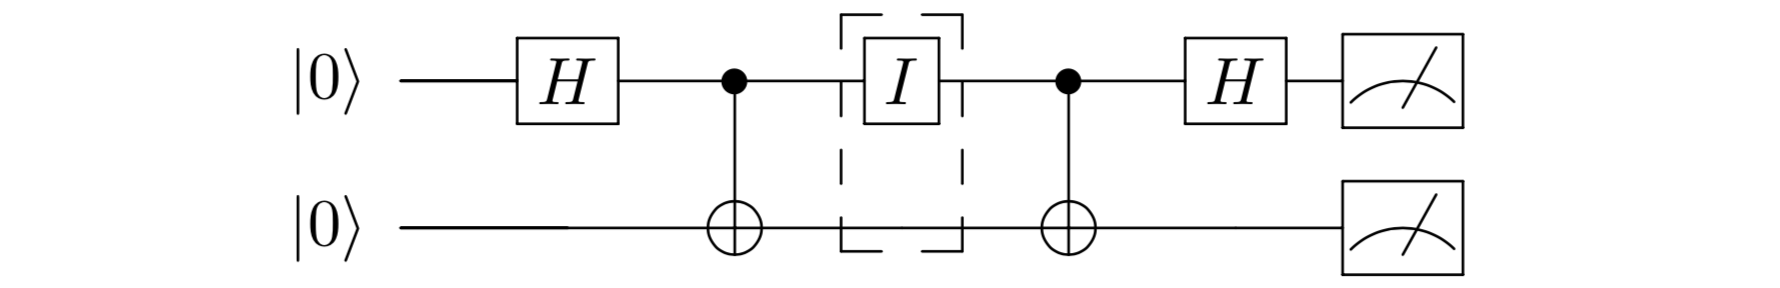

## Code

In [1]:
# Print version of SDK
!pip show amazon-braket-sdk | grep Version

# Import Braket libraries
from braket.circuits import Circuit, Gate, Moments
from braket.circuits.instruction import Instruction
from braket.aws import AwsDevice
import matplotlib.pyplot as plt
import boto3
import time

Version: 0.5.0


Typically, we recommend to run circuits <25 qubits on the local simulator to avoid latency bottlenecks. The managed, high-performance simulator SV1 is better suited for larger circuits up to 34 qubits. Nevertheless, for demonstration purposes, we are going to continue this example with SV but it is easy to switch over to the local simulator by replacing the last line in the cell below with ```device = LocalSimulator()```

In [2]:
# Please enter the S3 bucket you created during onboarding in the code below, 
# or create a new bucket named as ‘amazon-braket-<your account number>’ to run the below code without changes. 
aws_account_id = boto3.client("sts").get_caller_identity()["Account"]
my_bucket = f"amazon-braket-{aws_account_id}" # the name of the bucket
my_prefix = "simulation-output" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

# Select device arn for the managed simulator
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

In [3]:
# Function to run quantum task, check the status thereof and collect results
def get_result(device, circ, s3_folder):
    
    # get number of qubits
    num_qubits = circ.qubit_count

    # specify desired results_types
    circ.probability()

    # submit task: define task (asynchronous)
    if device.name == 'DefaultSimulator':
        task = device.run(circ, shots=1000)
    else:
        task = device.run(circ, s3_folder,
                          shots=1000, 
                          poll_timeout_seconds=1000)

    # Get ID of submitted task
    task_id = task.id
#     print('Task ID :', task_id)

    # Wait for job to complete
    status_list = []
    status = task.state()
    status_list += [status]
    print('Status:', status)

    # Only notify the user when there's a status change
    while status != 'COMPLETED':
        status = task.state()
        if status != status_list[-1]:
            print('Status:', status)
        status_list += [status]

    # get result
    result = task.result()

    # get metadata
    metadata = result.task_metadata

    # get output probabilities
    probs_values = result.values[0]

    # get measurment results
    measurement_counts = result.measurement_counts

    # print measurment results
    print('measurement_counts:', measurement_counts)

    # bitstrings
    format_bitstring = '{0:0' + str(num_qubits) + 'b}'
    bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

    # plot probabalities
    plt.bar(bitstring_keys, probs_values);
    plt.xlabel('bitstrings');
    plt.ylabel('probability');
    plt.xticks(rotation=90);
    plt.show() 
    
    return measurement_counts

Alice and Bob initially share a Bell pair.  Let's create this now:

In [4]:
circ = Circuit();
circ.h([0]);
circ.cnot(0,1);

Define Alice's encoding scheme according to the table above.  Alice selects one of these messages to send.

In [5]:
# Four possible messages and their corresponding gates
message = {"00": Circuit().i(0),
           "01": Circuit().x(0),
           "10": Circuit().z(0),
           "11": Circuit().x(0).z(0)
          }

In [6]:
# Select message to send.  Let's start with '01' for now
m = "01"

Alice encodes her message by applying the gates defined above

In [7]:
# Encode the message
circ.add_circuit(message[m]);

Alice then sends her qubit to Bob so that Bob has both qubits in his lab.  Bob decodes Alice's message by disentangling the two qubits:

In [8]:
circ.cnot(0,1);
circ.h([0]);

The full circuit now looks like

In [9]:
print(circ)

T  : |0|1|2|3|4|
                
q0 : -H-C-X-C-H-
        |   |   
q1 : ---X---X---

T  : |0|1|2|3|4|


By measuring the two qubits in the computational basis, Bob can read off Alice's two qubit message

Status: CREATED
Status: QUEUED
Status: RUNNING
Status: COMPLETED
measurement_counts: Counter({'01': 1000})


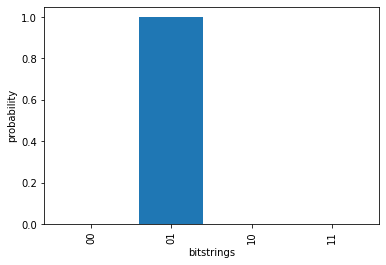

Counter({'01': 1000})


In [10]:
counts = get_result(device, circ, s3_folder)
print(counts)

We can check that this scheme works for the other possible messages too:

Status: CREATED
Status: QUEUED
Status: RUNNING
Status: COMPLETED
measurement_counts: Counter({'00': 1000})


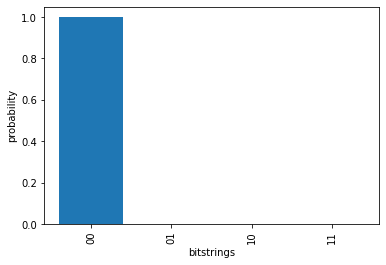

Message: 00. Results:
Counter({'00': 1000})
Status: CREATED
Status: QUEUED
Status: RUNNING
Status: COMPLETED
measurement_counts: Counter({'01': 1000})


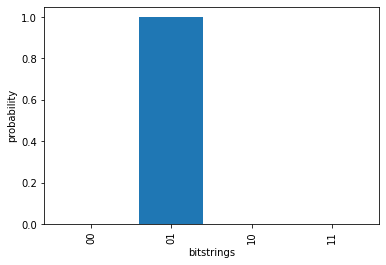

Message: 01. Results:
Counter({'01': 1000})
Status: CREATED
Status: QUEUED
Status: RUNNING
Status: COMPLETED
measurement_counts: Counter({'10': 1000})


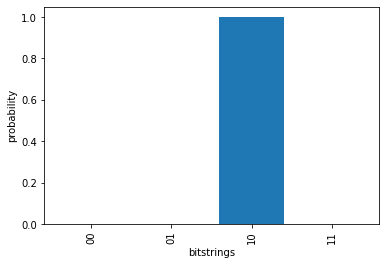

Message: 10. Results:
Counter({'10': 1000})
Status: CREATED
Status: QUEUED
Status: RUNNING
Status: COMPLETED
measurement_counts: Counter({'11': 1000})


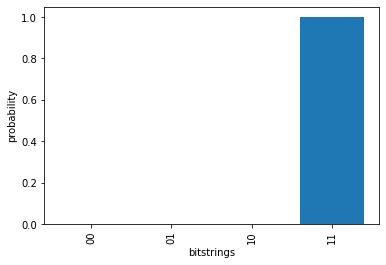

Message: 11. Results:
Counter({'11': 1000})


In [11]:
for m in message:
    
    # Reproduce the full circuit above by concatenating all of the gates:
    newcirc = Circuit().h([0]).cnot(0,1).add_circuit(message[m]).cnot(0,1).h([0]);
    
    # Run the circuit:
    counts = get_result(device, newcirc, s3_folder)
    
    print("Message: " + m + ". Results:")
    print(counts)